Get the feature data and any other data we need from MongoDB

In [1]:
%matplotlib inline

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from pymongo import MongoClient
import pymongo

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 8

In [2]:
client = MongoClient("localhost", 27017)
db = client["microscopium"]

In [3]:
# get z scores and sample type (empty, control type, etc)
docs = db.samples.find({"screen":"KEEFE"}).sort([("_id", pymongo.ASCENDING)])

scores = {}

scores["average_EduAvgInten_normalised_to_OTP_robust_z_scored"] = []
scores["average_EduTotalInten_normalised_to_OTP_robust_z_scored"] = []
scores["average_NucSize_normalised_to_OTP_robust_z_scored"] = []
scores["average_NucArea_normalised_to_OTP_robust_z_scored"] = []
scores["average_NucSize_normalised_to_OTP_robust_z_scored"] = []
scores["average_cell_count_normalised_to_OTP_robust_z_scored"] = []

coding = []

for doc in docs:
    for key in scores.keys():
        scores[key].append(doc["overlays"][key])
        
    if doc["empty"] == True:
        coding.append('empty')
    elif doc["control_pos"] == True:
        coding.append("control_pos")
    elif doc["control_neg"] == True:
        coding.append("control_neg")
    else:
        coding.append("treated")

In [4]:
data = pd.read_csv("../microscopium-data/KEEFE-features.csv", index_col=0)
feature_cols = data.columns
data["type"] = coding

for score in scores.keys():
    data[score] = scores[score]

Create linear regression models -- we are really only interested in wells that were actually treated. Empty wells and controls were exluded from the z-score analysis and carry a default score of 0. For each model, get the r^2 score.

In [5]:
data_experimental = data[data["type"].isin(["treated"])]
scaler = StandardScaler()
data_experimental_std = scaler.fit_transform(data_experimental[feature_cols])

In [6]:
# fit simple linear regression models for each
def fit_models(data, scores):
    for key in scores.keys():
        X = data
        y = data_experimental[key]
        regression = LinearRegression()
        regression.fit(X, y)
        score = regression.score(X, y)
        print("{0}, {1}".format(key, score))
        
fit_models(data_experimental_std, scores)

average_NucArea_normalised_to_OTP_robust_z_scored, 0.41159245211004136
average_cell_count_normalised_to_OTP_robust_z_scored, 0.4368591429830658
average_EduAvgInten_normalised_to_OTP_robust_z_scored, 0.4049269854303007
average_NucSize_normalised_to_OTP_robust_z_scored, 0.3958513341827407
average_EduTotalInten_normalised_to_OTP_robust_z_scored, 0.4198962966951594


Okay, that's pretty decent! How about in the lower dimension space? How well does the positive correlation hold up?

In [7]:
data_pca_50 = PCA(n_components=50).fit_transform(data_experimental_std)
data_pca = PCA(n_components=2).fit_transform(data_experimental_std)
data_tsne = TSNE(n_components=2).fit_transform(data_pca_50)

In [8]:
fit_models(data_pca_50, scores)

average_NucArea_normalised_to_OTP_robust_z_scored, 0.3180538575982623
average_cell_count_normalised_to_OTP_robust_z_scored, 0.3341708178669164
average_EduAvgInten_normalised_to_OTP_robust_z_scored, 0.35730358281972857
average_NucSize_normalised_to_OTP_robust_z_scored, 0.3479175725453516
average_EduTotalInten_normalised_to_OTP_robust_z_scored, 0.3293925224927975


In [9]:
fit_models(data_pca, scores)

average_NucArea_normalised_to_OTP_robust_z_scored, 0.16651528098509283
average_cell_count_normalised_to_OTP_robust_z_scored, 0.1635645438097586
average_EduAvgInten_normalised_to_OTP_robust_z_scored, 0.2758319516363581
average_NucSize_normalised_to_OTP_robust_z_scored, 0.26337580265512694
average_EduTotalInten_normalised_to_OTP_robust_z_scored, 0.1835382230461503


In [10]:
fit_models(data_tsne, scores)

average_NucArea_normalised_to_OTP_robust_z_scored, 0.13347026563745312
average_cell_count_normalised_to_OTP_robust_z_scored, 0.1362675614539871
average_EduAvgInten_normalised_to_OTP_robust_z_scored, 0.21157505756534056
average_NucSize_normalised_to_OTP_robust_z_scored, 0.1975994092433313
average_EduTotalInten_normalised_to_OTP_robust_z_scored, 0.14945888970359344


How do the plots look with z-scores overlaid?

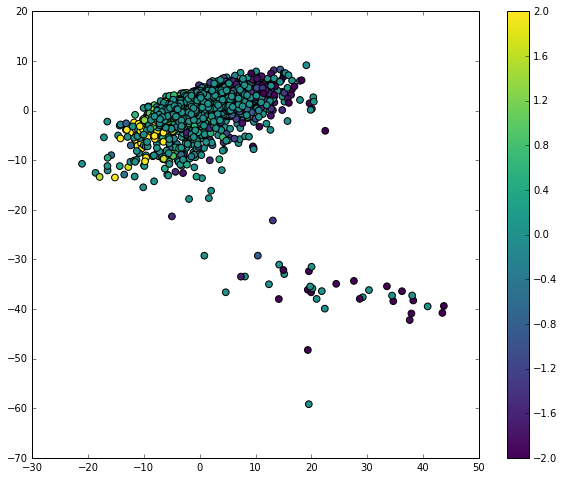

In [11]:
key = "average_EduAvgInten_normalised_to_OTP_robust_z_scored"
plt.scatter(data_pca[:, 0], data_pca[:, 1], s=45, c=data_experimental[key], cmap="viridis", vmin=-2, vmax=2)
plt.colorbar()

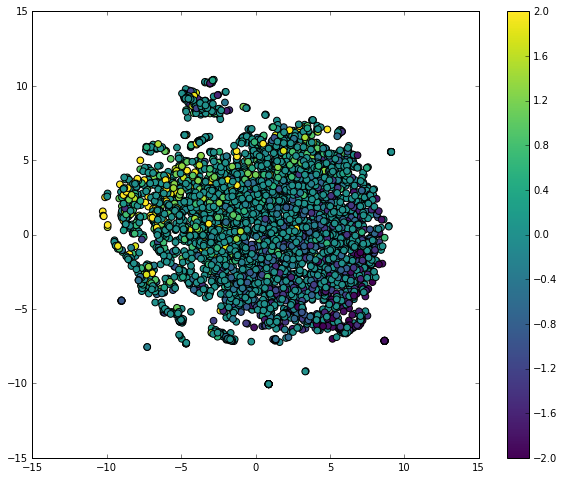

In [12]:
key = "average_EduAvgInten_normalised_to_OTP_robust_z_scored"
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], s=45, c=data_experimental[key], cmap="viridis", vmin=-2, vmax=2)
plt.colorbar()